In [13]:
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt

In [14]:
def DFT(x):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

def FFT(x):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]

    if N & (N - 1) != 0:  # Not a power of 2
        return DFT(x)  # Use DFT as fallback
    elif N <= 32:
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even + factor[N // 2:] * X_odd])

In [15]:
def fft_shift(fft_result):
    rows, cols = fft_result.shape
    half_rows, half_cols = rows // 2, cols // 2
    shifted_fft_result = np.empty_like(fft_result)
    shifted_fft_result[:half_rows, :half_cols] = fft_result[half_rows:, half_cols:]
    shifted_fft_result[:half_rows, half_cols:] = fft_result[half_rows:, :half_cols]
    shifted_fft_result[half_rows:, :half_cols] = fft_result[:half_rows, half_cols:]
    shifted_fft_result[half_rows:, half_cols:] = fft_result[:half_rows, :half_cols]
    return shifted_fft_result

In [16]:
def fft_process(filenames):
    for filename in filenames:
        print(f"\nProcessing {filename} ...")
        
        img = image.imread(filename)
        new_img = np.zeros([img.shape[0], img.shape[1]], dtype=complex)

        # Row-wise FFT
        for i in range(img.shape[0]):
            row = img[i, :].astype(complex)
            transformed_row = FFT(row)
            new_img[i, :] = transformed_row

        # Column-wise FFT
        new_img_final = np.zeros([img.shape[0], img.shape[1]], dtype=complex)
        for i in range(img.shape[1]):
            column = new_img[:, i]
            transformed_column = FFT(column)
            new_img_final[:, i] = transformed_column

        # Apply FFT shift
        fft_shifted_img = fft_shift(new_img_final)

        # Magnitude & Phase
        magnitude_spectrum = np.abs(fft_shifted_img)
        log_magnitude = np.log1p(magnitude_spectrum)
        phase_spectrum = np.angle(fft_shifted_img)

        # Generate save prefix from filename (without extension)
        save_prefix = filename.rsplit('.', 1)[0]

        # Save images
        plt.imsave(f"{save_prefix}_magnitude.png", log_magnitude, cmap='gray')
        plt.imsave(f"{save_prefix}_phase.png", phase_spectrum, cmap='gray')

        # Optionally display
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(log_magnitude, cmap='gray')
        plt.title('Magnitude Spectrum (log scale)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(phase_spectrum, cmap='gray')
        plt.title('Phase Spectrum')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Saved {save_prefix}_magnitude.png and {save_prefix}_phase.png")




Processing cameraman.jpg ...


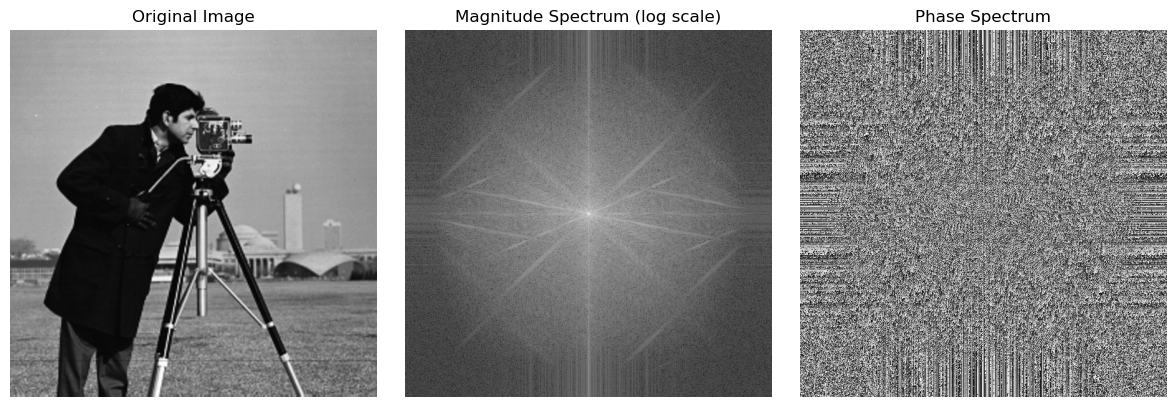

Saved cameraman_magnitude.png and cameraman_phase.png

Processing jetplane.jpg ...


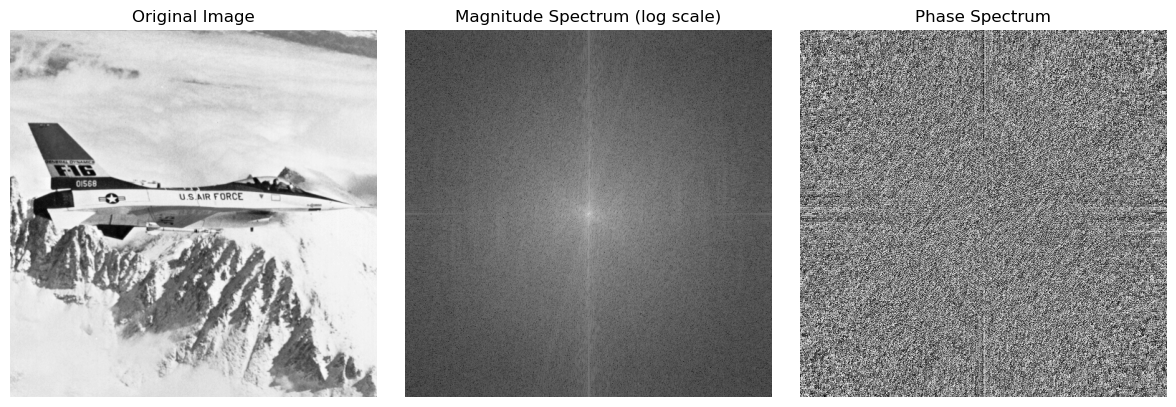

Saved jetplane_magnitude.png and jetplane_phase.png

Processing lake.jpg ...


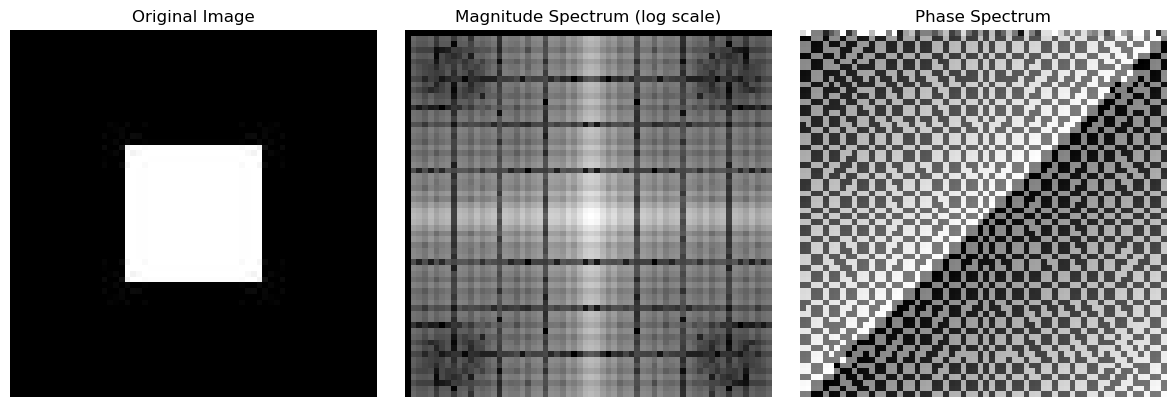

Saved lake_magnitude.png and lake_phase.png

Processing lena_gray_512.jpg ...


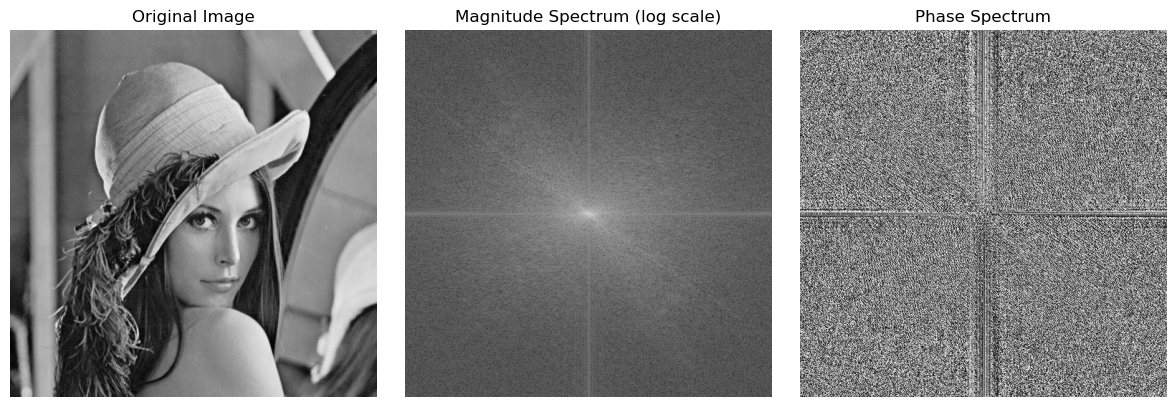

Saved lena_gray_512_magnitude.png and lena_gray_512_phase.png

Processing livingroom.jpg ...


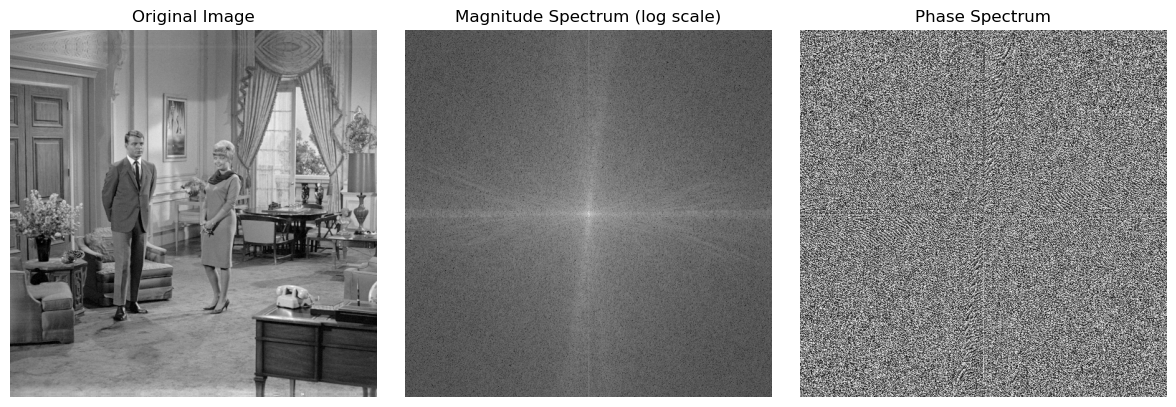

Saved livingroom_magnitude.png and livingroom_phase.png

Processing mandril_gray.jpg ...


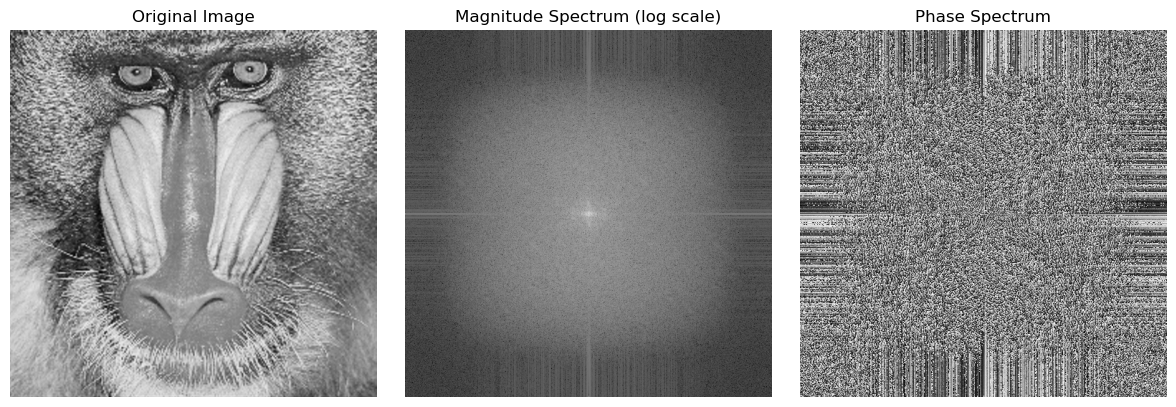

Saved mandril_gray_magnitude.png and mandril_gray_phase.png

Processing pirate.jpg ...


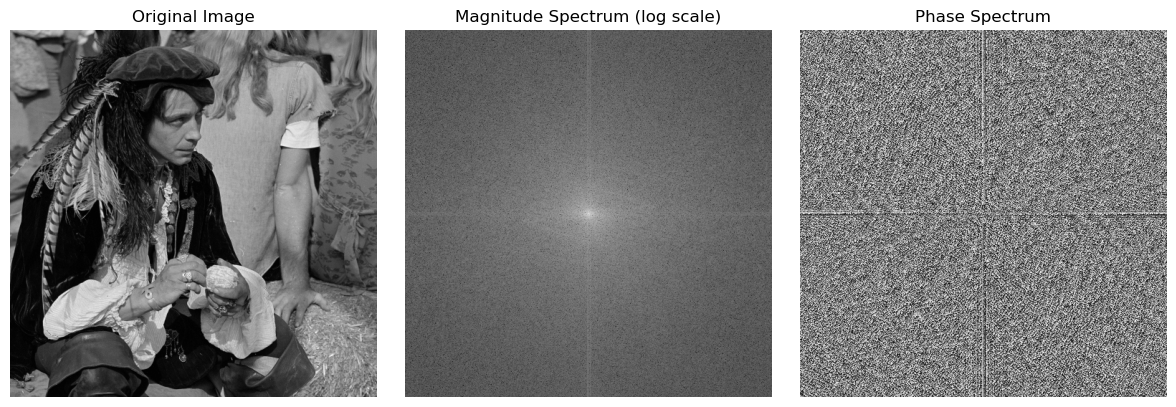

Saved pirate_magnitude.png and pirate_phase.png

Processing walkbridge.jpg ...


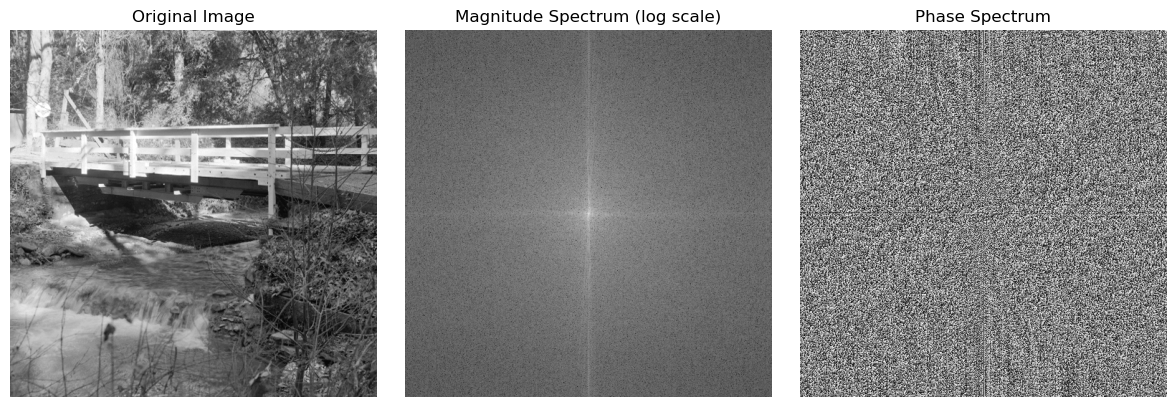

Saved walkbridge_magnitude.png and walkbridge_phase.png


In [17]:
filenames = ["cameraman.jpg","jetplane.jpg","lena_gray_512.jpg","livingroom.jpg","mandril_gray.jpg","pirate.jpg","walkbridge.jpg"]
fft_process(filenames)


In [18]:
def IFFT(x):
    N = len(x)
    x_conj = np.conj(x)
    X = FFT(x_conj)
    X = np.conj(X) / N
    return X

def ifft_shift(ifft_result):
    rows, cols = ifft_result.shape
    half_rows, half_cols = rows // 2, cols // 2
    shifted_ifft_result = np.empty_like(ifft_result)
    shifted_ifft_result[:half_rows, :half_cols] = ifft_result[half_rows:, half_cols:]
    shifted_ifft_result[:half_rows, half_cols:] = ifft_result[half_rows:, :half_cols]
    shifted_ifft_result[half_rows:, :half_cols] = ifft_result[:half_rows, half_cols:]
    shifted_ifft_result[half_rows:, half_cols:] = ifft_result[:half_rows, :half_cols]
    
    return shifted_ifft_result

In [19]:
def reconstruct(filename):
    
    for filename in filenames:
        print(f"\nProcessing {filename} ...")
        
        img = image.imread(filename)
        new_img = np.zeros([img.shape[0], img.shape[1]], dtype=complex)

        # Row-wise FFT
        for i in range(img.shape[0]):
            row = img[i, :].astype(complex)
            transformed_row = FFT(row)
            new_img[i, :] = transformed_row

        # Column-wise FFT
        new_img_final = np.zeros([img.shape[0], img.shape[1]], dtype=complex)
        for i in range(img.shape[1]):
            column = new_img[:, i]
            transformed_column = FFT(column)
            new_img_final[:, i] = transformed_column

        # Apply FFT shift
        fft_shifted_img = fft_shift(new_img_final)
        
        print("\nStarting image reconstruction...")

        shifted_ifft_result = ifft_shift(fft_shifted_img)
        print(f"IFFT input shape: {shifted_ifft_result.shape}")

        print("Computing column-wise IFFT...")
        recon_img = np.zeros([img.shape[0], img.shape[1]], dtype=complex)
        for i in range(img.shape[1]): 
            column = shifted_ifft_result[:, i]  
            transformed_column = IFFT(column)
            recon_img[:, i] = transformed_column

        print("Computing row-wise IFFT...")
        recon_img_final = np.zeros([img.shape[0], img.shape[1]], dtype=complex)
        for i in range(img.shape[0]):
            row = recon_img[i, :].astype(complex)  
            transformed_row = IFFT(row)  
            recon_img_final[i, :] = transformed_row

        reconstructed_image = np.abs(recon_img_final)


        save_prefix = filename.rsplit('.', 1)[0]
        plt.imsave(f"{save_prefix}_reconstructed.png",reconstructed_image, cmap='gray')
        print(f"Saved {save_prefix}_reconstructed.png")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_image, cmap='gray')
        plt.title('Reconstructed Image')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Calculate reconstruction error
        error = np.mean(np.abs(img.astype(float) - reconstructed_image))
        print(f"Reconstruction error: {error:.6f}")


Processing cameraman.jpg ...

Starting image reconstruction...
IFFT input shape: (512, 512)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved cameraman_reconstructed.png


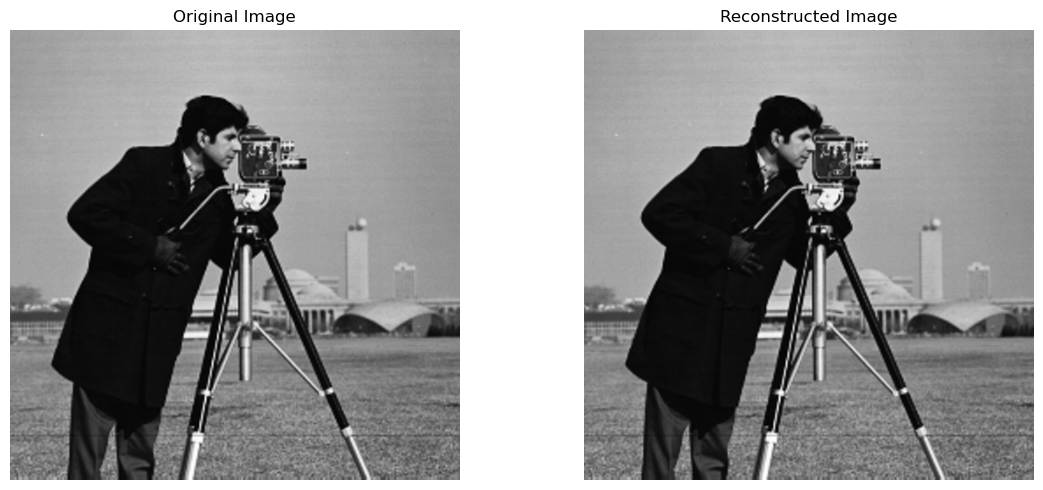

Reconstruction error: 0.000000

Processing jetplane.jpg ...

Starting image reconstruction...
IFFT input shape: (512, 512)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved jetplane_reconstructed.png


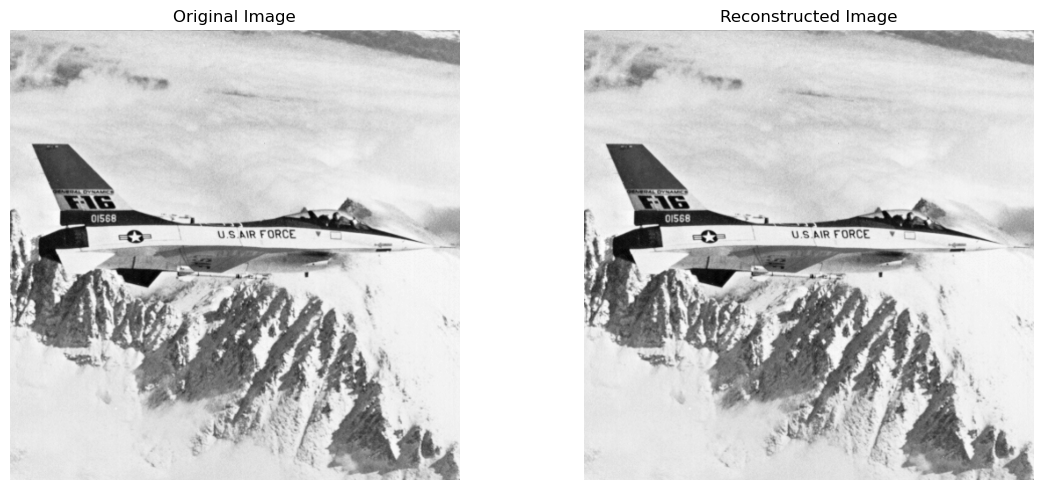

Reconstruction error: 0.000000

Processing lake.jpg ...

Starting image reconstruction...
IFFT input shape: (64, 64)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved lake_reconstructed.png


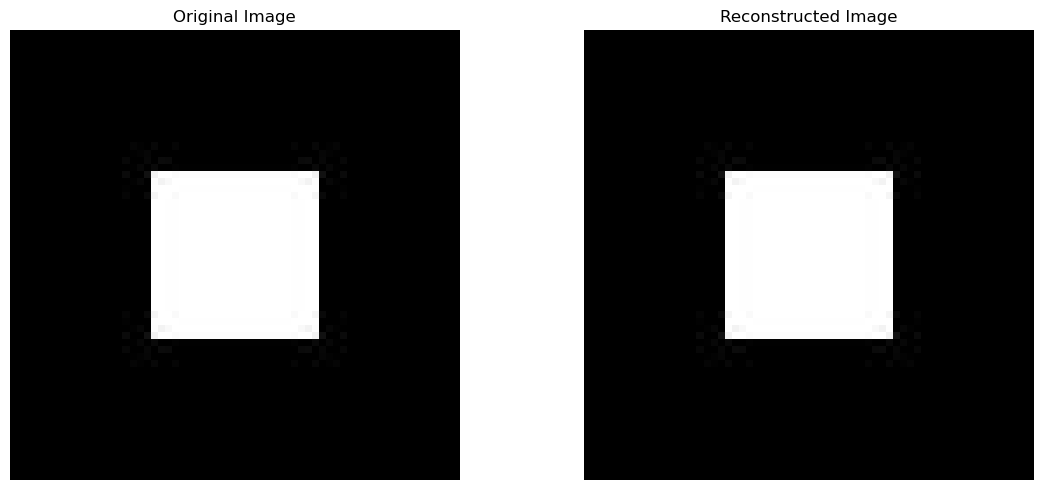

Reconstruction error: 0.000000

Processing lena_gray_512.jpg ...

Starting image reconstruction...
IFFT input shape: (512, 512)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved lena_gray_512_reconstructed.png


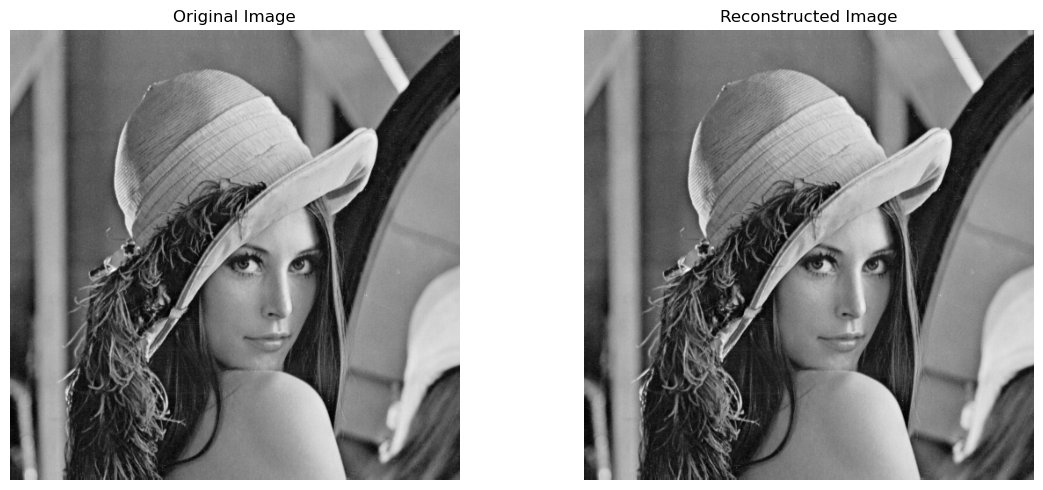

Reconstruction error: 0.000000

Processing livingroom.jpg ...

Starting image reconstruction...
IFFT input shape: (512, 512)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved livingroom_reconstructed.png


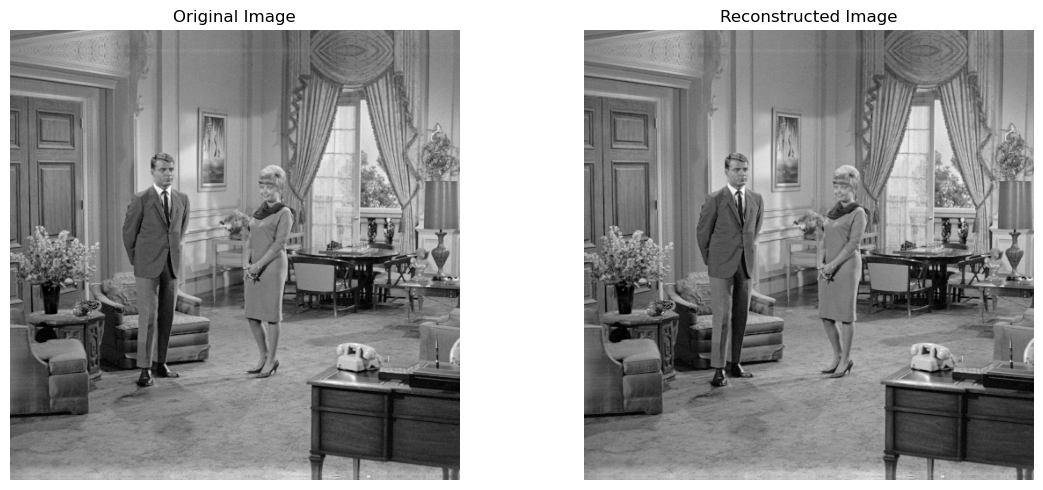

Reconstruction error: 0.000000

Processing mandril_gray.jpg ...

Starting image reconstruction...
IFFT input shape: (512, 512)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved mandril_gray_reconstructed.png


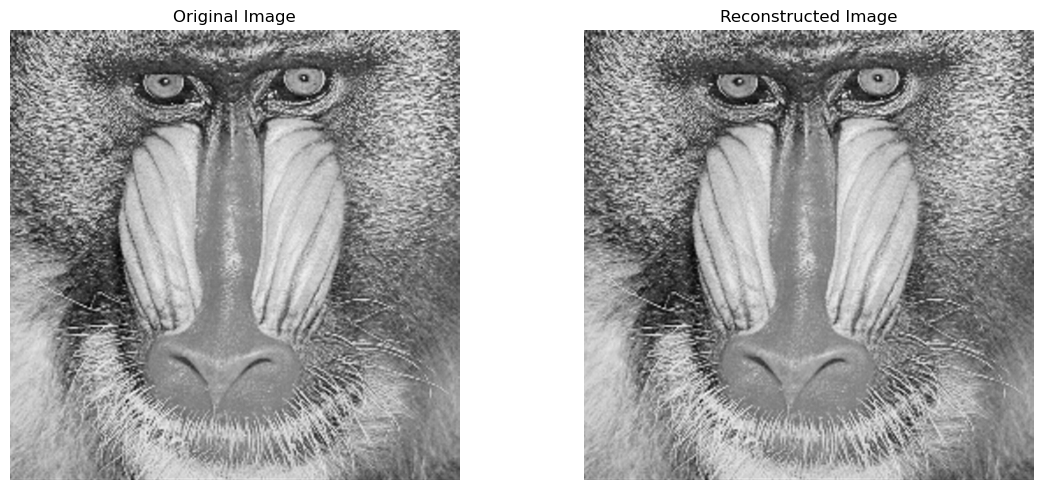

Reconstruction error: 0.000000

Processing pirate.jpg ...

Starting image reconstruction...
IFFT input shape: (512, 512)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved pirate_reconstructed.png


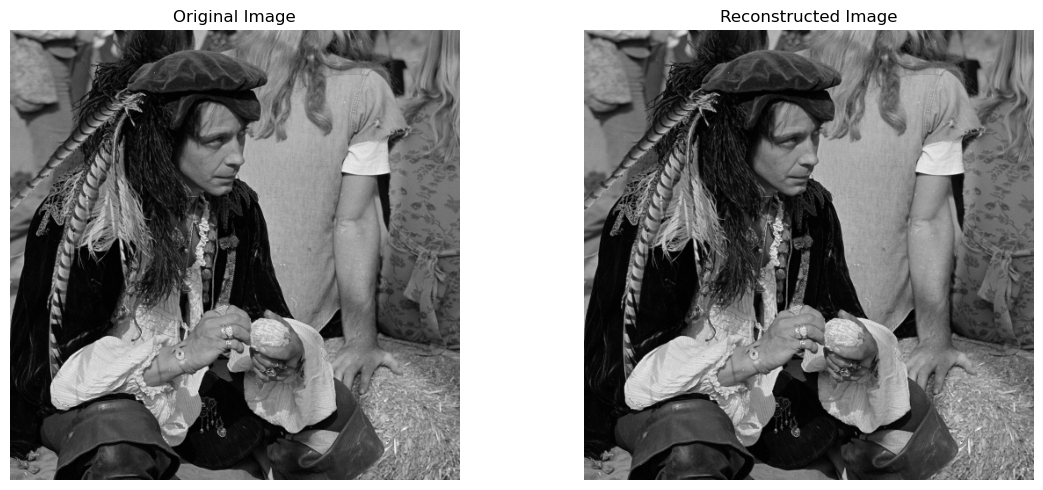

Reconstruction error: 0.000000

Processing walkbridge.jpg ...

Starting image reconstruction...
IFFT input shape: (512, 512)
Computing column-wise IFFT...
Computing row-wise IFFT...
Saved walkbridge_reconstructed.png


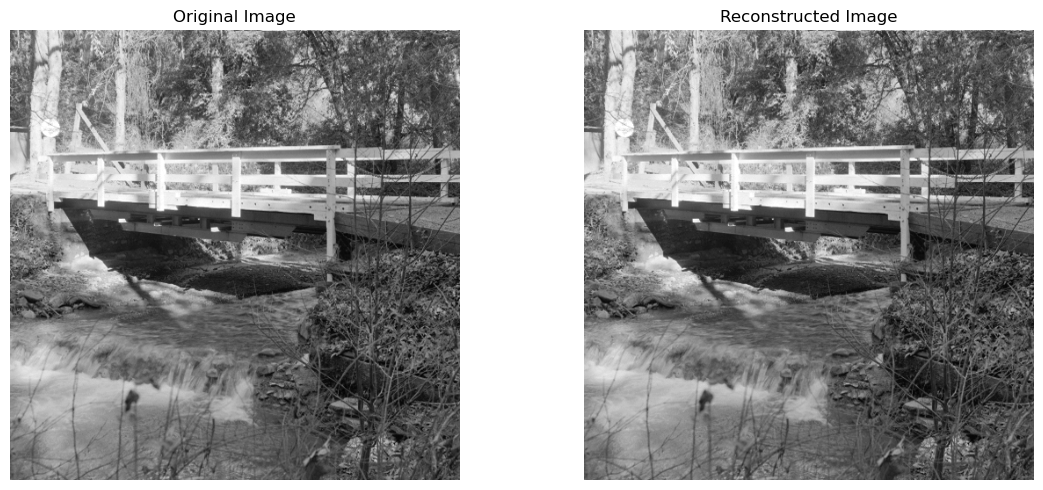

Reconstruction error: 0.000000


In [20]:

reconstruct(filenames)

# PART 2

In [21]:
tiff_file = 'dip.tif'

try:
    I = plt.imread(tiff_file)
    print(f"Successfully loaded TIFF: {I.shape}")
except FileNotFoundError:
    print(f"Warning: '{tiff_file}' not found. Using previous image.")
    I = img

print(I.shape)

Successfully loaded TIFF: (256, 256)
(256, 256)


In [22]:
new_I = np.zeros([I.shape[0], I.shape[1]])
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        new_I[i][j] = np.power(-1, (i + j)) * I[i][j]

print(f"Centered image range: [{np.min(new_I):.2f}, {np.max(new_I):.2f}]")
print(f"Unique values: {len(np.unique(new_I))}")


print("Computing row-wise FFT on centered image...")
new_img2 = np.zeros([I.shape[0], I.shape[1]], dtype=complex)
for i in range(I.shape[0]):
    row = new_I[i, :].astype(complex)
    transformed_row = FFT(row)
    new_img2[i, :] = transformed_row
    
print("Computing column-wise FFT on centered image...")
new_img_final2 = np.zeros([I.shape[0], I.shape[1]], dtype=complex)
for i in range(I.shape[1]):  

    column = new_img2[:, i]
    transformed_column = FFT(column)
    new_img_final2[:, i] = transformed_column

Centered image range: [-255.00, 255.00]
Unique values: 33
Computing row-wise FFT on centered image...
Computing column-wise FFT on centered image...


In [23]:
fft_conjugate = np.conjugate(new_img_final2)


print("Computing column-wise IFFT...")
recon_img2 = np.zeros([I.shape[0], I.shape[1]], dtype=complex)
for i in range(I.shape[1]):  

    column = fft_conjugate[:, i]
    transformed_column = IFFT(column)
    recon_img2[:, i] = transformed_column

Computing column-wise IFFT...


Computing row-wise IFFT...


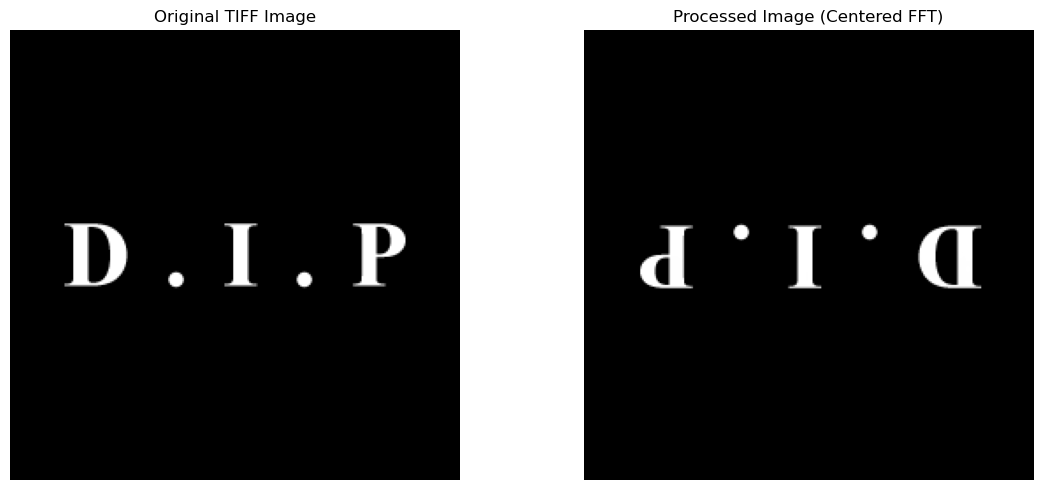

Processing complete. Output saved as 'dip_output.tif'

=== All processing completed successfully ===


In [24]:

print("Computing row-wise IFFT...")
recon_img_final2 = np.zeros([I.shape[0], I.shape[1]], dtype=complex)
for i in range(I.shape[0]):

    row = recon_img2[i, :].astype(complex)
    transformed_row = IFFT(row)  
    recon_img_final2[i, :] = transformed_row

# Apply inverse centering transform
new_I_final = np.zeros([I.shape[0], I.shape[1]])
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        new_I_final[i][j] = np.power(-1, (i + j)) * np.real(recon_img_final2[i][j])



plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Original TIFF Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.uint8(np.clip(new_I_final, 0, 255)), cmap='gray')  
plt.title('Processed Image (Centered FFT)')
plt.axis('off')

plt.tight_layout()
plt.savefig('dip_output.tif', dpi=300, bbox_inches='tight')
plt.show()

print("Processing complete. Output saved as 'dip_output.tif'")
print("\n=== All processing completed successfully ===")